In [1]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import re
import random

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
# Path to the folder containing the images you want to analyze
IMAGE_FOLDER_PATH = "Data/images/"

IMAGE_SPEC = "Apatite1"

SUB_DIR = "/tiles"

IMAGE_PATH = os.path.join(IMAGE_FOLDER_PATH, IMAGE_SPEC + SUB_DIR)
# Path to the trained model file (.pth) saved from the training notebook
MODEL_FOLDER_PATH = "Data/segmentation_models/"

MODEL_SPEC = "obsidian_a066b033beta20" 
MODEL_EXT = ".pth"

MODEL_PATH = os.path.join(MODEL_FOLDER_PATH, MODEL_SPEC + MODEL_EXT)

# Path to the directory where results  will be saved
OUTPUT_FOLDER_PATH = "Data/inference_results"
OUTPUT_SPEC = IMAGE_SPEC + "_" + MODEL_SPEC + ".csv"

OUTPUT_PATH = os.path.join(OUTPUT_FOLDER_PATH, OUTPUT_SPEC)

# ---  MODEL PARAMETERS (These MUST match the model you are loading) ---
MODEL_ARC = "Unet"
ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"

# --- 3. PREPROCESSING PARAMETERS (These MUST match how the model was trained) ---
# Image dimensions the model was trained on
IMG_HEIGHT = 1024
IMG_WIDTH = 1024
# Number of channels in the *source* images (1 for grayscale, 3 for color).
INPUT_CHANNELS_CONFIG = 3

# Set to None if unknown.
PIXEL_RESOLUTION_UM_PER_PX = 0.345

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.isdir(IMAGE_PATH):
    raise FileNotFoundError(f"ERROR: Image folder not found at '{IMAGE_PATH}'")
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"ERROR: Model file not found at '{MODEL_PATH}'")

print(f"Configuration Loaded:")
print(f"  Image Folder: {IMAGE_PATH}")
print(f"  Model Path: {MODEL_PATH}")
print(f"  Output Directory: {OUTPUT_PATH}")
print(f"  Using Device: {DEVICE}")

Configuration Loaded:
  Image Folder: Data/images/Apatite1/tiles
  Model Path: Data/segmentation_models/obsidian_a066b033beta20.pth
  Output Directory: Data/inference_results/Apatite1_obsidian_a066b033beta20.csv
  Using Device: cpu


In [3]:
def get_preprocessing(preprocessing_fn):
    """Combines model-specific normalization with tensor conversion."""
    _transform = [
        A.Lambda(image=preprocessing_fn),
        ToTensorV2(),
    ]
    return A.Compose(_transform)

In [4]:
print("Loading trained model...")

try:
    # Instantiate the model with the same architecture as during training
    inference_model = smp.create_model(
        arch=MODEL_ARC,
        encoder_name=ENCODER,
        encoder_weights=None,
        in_channels=INPUT_CHANNELS_CONFIG,
        classes=1,
        activation=None, 
    )
    inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    inference_model.to(DEVICE)
    inference_model.eval()
    print("Model loaded successfully and set to evaluation mode.")
except Exception as e:
    print(f"Error creating or loading model: {e}")
    print("Please ensure MODEL_ARC and ENCODER parameters in Cell 2 are correct.")
    raise e

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
print("Preprocessing function loaded.")

Loading trained model...
Model loaded successfully and set to evaluation mode.
Preprocessing function loaded.


In [5]:
image_files = sorted(glob.glob(os.path.join(IMAGE_PATH, '*.png')))

file_pattern = re.compile(r'Frame(\d+)_Acquisition_(\d+)_(\d+)_(\d+).png')

image_groups = defaultdict(list)

for fpath in image_files:
    fname = os.path.basename(fpath)
    match = file_pattern.match(fname)
    if match:
        n, image_id, top, left = match.groups()
        group_key = f"Frame{n}_{top}_{left}"
        image_groups[group_key].append(fpath)

print(f"Found {len(image_files)} total images.")
print(f"Grouped into {len(image_groups)} unique locations (Z-stacks). Each should have {len(list(image_groups.values())[0])} images.")

Found 2816 total images.
Grouped into 256 unique locations (Z-stacks). Each should have 11 images.


Starting ellipse fitting...


Ellipse Analysis:   0%|          | 0/256 [00:00<?, ?it/s]

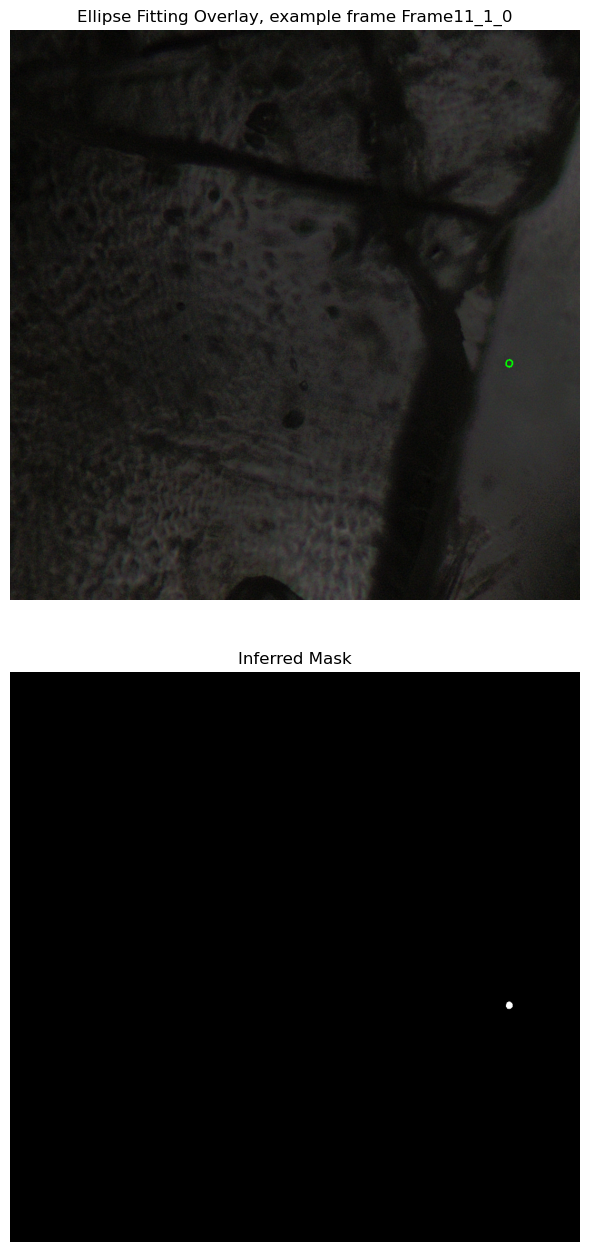

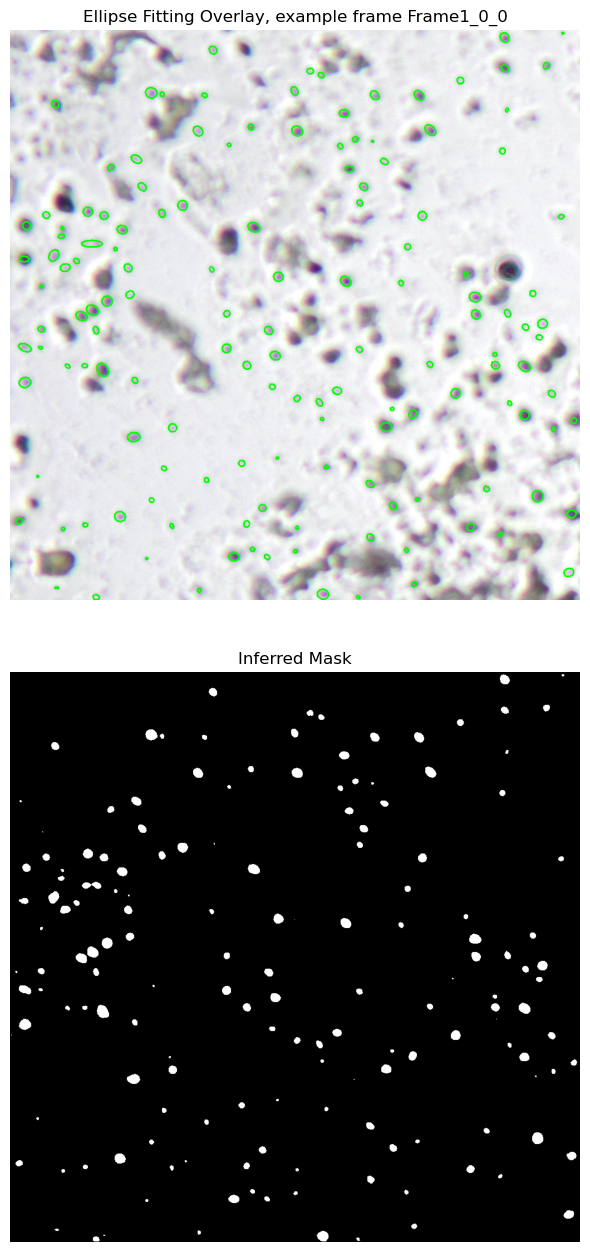

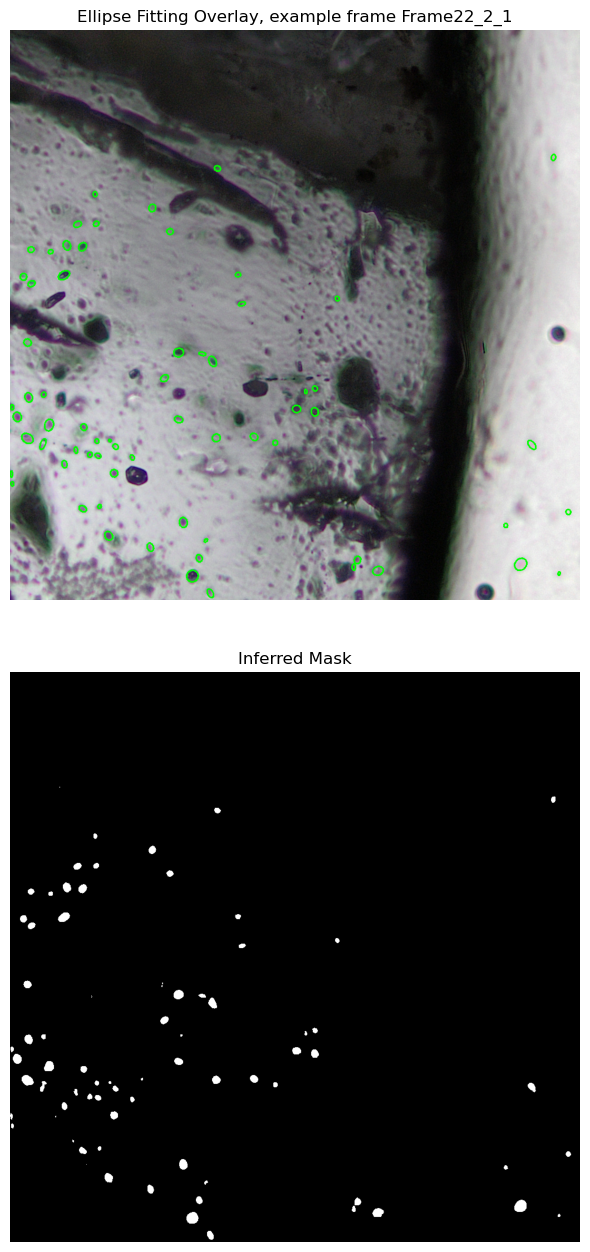

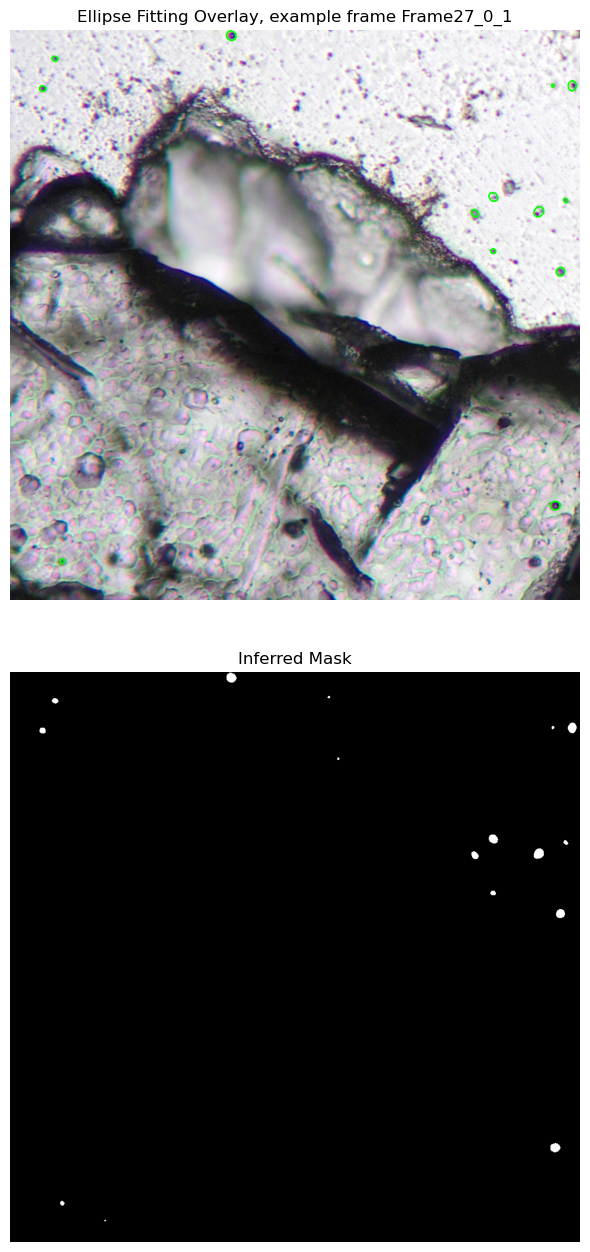

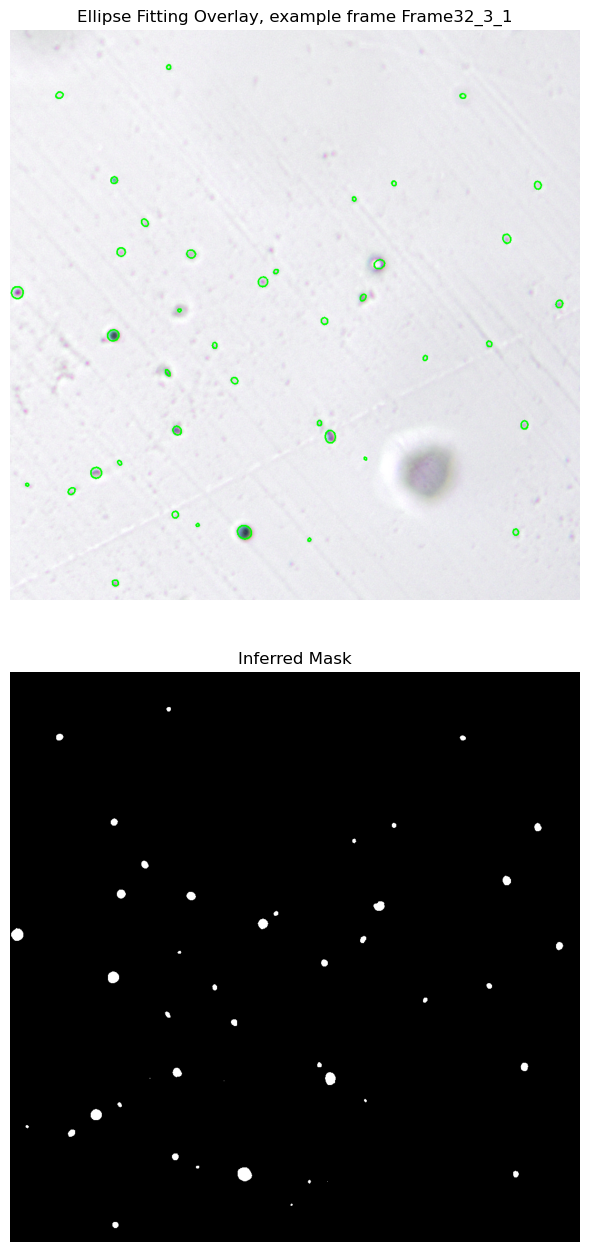


--- Ellipse Fitting Results ---
Total tracks found across all images: 18294
Scanned 256 frames of area 0.00125 cm2, for a total area of 0.320 cm2 
Resulting track density is 57257.266 cm-2
Sample of detected track and ellipse properties:
                      image_filename  track_id  centroid_x_px_ellipse  \
0  Frame10_Acquisition_14003_0_0.png         1                    6.3   
1  Frame10_Acquisition_14003_0_0.png         2                   38.8   
2  Frame10_Acquisition_14003_0_0.png         3                    3.4   
3  Frame10_Acquisition_14003_0_0.png         4                   38.6   
4  Frame10_Acquisition_14003_0_0.png         5                    7.8   

   centroid_y_px_ellipse  major_axis_px  minor_axis_px  orientation_deg  \
0                  868.1          14.91          14.08           141.55   
1                  588.6           8.47           7.88            11.78   
2                  373.8          10.91           6.83           167.39   
3                  371

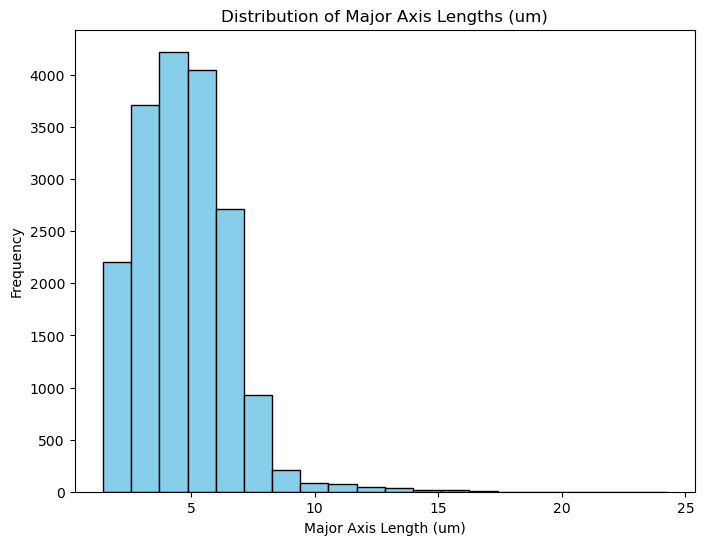

In [6]:
print("Starting ellipse fitting...")

ellipse_analysis_results = []

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
preprocessing = get_preprocessing(preprocessing_fn)

all_keys = list(image_groups.keys())
num_samples = 5
selected_keys = random.sample(all_keys, min(len(all_keys), num_samples))

for group_key, file_list in tqdm(image_groups.items(), desc="Ellipse Analysis"):
    
    group_masks = []
    original_vis_image = None
    for idx, image_path in enumerate(file_list[:]):
        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if idx == 6:
            original_vis_image = image.copy()

        sample = preprocessing(image=image)
        preprocessed_image = sample['image'].unsqueeze(0).to(DEVICE, dtype=torch.float32)
        
        with torch.no_grad():
            pred_output = inference_model(preprocessed_image)
            pred_probs = torch.sigmoid(pred_output)
            pr_mask = (pred_probs.squeeze().cpu().numpy().round())
        
        group_masks.append(pr_mask)
    
    # Aggregate the masks (Logical OR across the Z-stack)
    aggregated_mask = np.max(np.stack(group_masks, axis=0), axis=0).astype(np.uint8)
    # --- Ellipse Analysis ---
    
    ellipse_vis_image = original_vis_image.copy()

    # Use cv2.findContours to get the boundary of each track/blob.
    # RETR_EXTERNAL: Retrieves only the extreme outer contours.
    # CHAIN_APPROX_SIMPLE: Compresses horizontal, vertical, and diagonal segments.
    contours, _ = cv2.findContours(aggregated_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    track_id_counter = 1
    
    for contour in contours:
        if cv2.contourArea(contour) < 10: # Minimum area to consider
            continue
    
        if len(contour) < 5:
            continue
            
        # 1. Fit the ellipse to the contour
        # The result is: ((center_x, center_y), (minor_axis_len, major_axis_len), orientation_deg)
        ellipse = cv2.fitEllipse(contour)

        cv2.ellipse(ellipse_vis_image, ellipse, (0, 255, 0), 2)
        
        ((center_x, center_y), (axis_a_px, axis_b_px), orientation_deg) = ellipse

        # OpenCV returns the two axes in an arbitrary order, so we ensure 
        # major is the larger value and minor is the smaller value.
        major_axis_len_px = max(axis_a_px, axis_b_px)
        minor_axis_len_px = min(axis_a_px, axis_b_px)
        
        # 3. Store properties
        track_props = {
            "image_filename": os.path.basename(file_list[0]), 
            "track_id": track_id_counter,
            "centroid_x_px_ellipse": round(center_x, 1), 
            "centroid_y_px_ellipse": round(center_y, 1),
            "major_axis_px": round(major_axis_len_px, 2),
            "minor_axis_px": round(minor_axis_len_px, 2),
            "orientation_deg": round(orientation_deg, 2),
        }
        
        # Convert to physical units if resolution is known (from Cell 2)
        if PIXEL_RESOLUTION_UM_PER_PX is not None:
            track_props['len_um'] = round(major_axis_len_px * PIXEL_RESOLUTION_UM_PER_PX, 2)

        ellipse_analysis_results.append(track_props)
        track_id_counter += 1

    if group_key in selected_keys:
        fig, axes = plt.subplots(2, 1, figsize=(6, 13))
            
        # Original + Ellipses
        axes[0].imshow(ellipse_vis_image)
        axes[0].set_title(f"Ellipse Fitting Overlay, example frame {group_key}")
        axes[0].axis('off')

        # Mask
        axes[1].imshow(aggregated_mask, cmap='gray')
        axes[1].set_title("Inferred Mask")
        axes[1].axis('off')


        plt.tight_layout()
        plt.show()


# 4. Convert results to a DataFrame and display a sample
df_ellipse_results = pd.DataFrame(ellipse_analysis_results)
df_ellipse_results.to_csv(OUTPUT_PATH)

img_area_cm2 = IMG_HEIGHT*IMG_WIDTH*(PIXEL_RESOLUTION_UM_PER_PX*1e-4)**2
tot_area_cm2 = len(image_groups)*img_area_cm2
track_density = len(df_ellipse_results)/tot_area_cm2

print(f"\n--- Ellipse Fitting Results ---\nTotal tracks found across all images: {len(df_ellipse_results)}")
print(f"Scanned {len(image_groups)} frames of area {img_area_cm2:0.5f} cm2, for a total area of {tot_area_cm2:0.3f} cm2 \nResulting track density is {track_density:0.3f} cm-2")
print("Sample of detected track and ellipse properties:")

# Display the dataframe with the new columns
print(df_ellipse_results.head())
 
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(df_ellipse_results['len_um'], bins=20, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Major Axis Lengths (um)')
ax.set_xlabel('Major Axis Length (um)')
ax.set_ylabel('Frequency')
plt.show()